In [18]:
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold


In [19]:
matrix = pd.read_csv('/home/bram/Project_PD/aa_test_2 matrix/training_set_final.csv')

# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']]

print(X_data)
print(y_data_pre)

print(X_data)
print(y_data_pre)
assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

# X_data=X_data.sample(frac=1, random_state=2023)
y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y = y_data_pre['annot']
print(y)

X_data=X_data.drop(['annot'], axis=1)
X=X_data.drop(['BDSPPatientID', 'CreateDate', 'hospital'], axis=1)
print(X)


      BDSPPatientID  CreateDate hospital  parkinson disease_pos  pd_pos  \
0         115418423  2022-08-02      MGB                      0       0   
1         115999654  2021-01-02      MGB                      0       0   
2         177513327  2016-05-26      STF                      0       0   
3         119646649  2019-08-02      MGB                      0       0   
4         151270446  2018-11-27    BIDMC                      1       0   
...             ...         ...      ...                    ...     ...   
1909      118500543  2020-09-19      MGB                      0       0   
1910      116178066  2020-11-08      MGB                      1       0   
1911      116687633  2017-03-30      MGB                      1       0   
1912      177538617  2017-09-19      STF                      0       0   
1913      112882252  2022-01-19      MGB                      0       0   

      parkinson_pos  parkinsonismx_pos  disease_pos  akathisia_pos  \
0                 0          

In [20]:
#  DROP ALL COLUMNS BEFORE ICD COLUMN
col_to_drop_up_to = 'ICD'

col_index = X.columns.get_loc(col_to_drop_up_to)

# Drop all columns up to and including the specified column
X = X.iloc[:, col_index :]

print(X.columns)
# DROP ALL COLUMNS AFTER ICD COLUMN
colindex2=X.columns.get_loc(col_to_drop_up_to)
X=X.iloc[: , :colindex2+1]
print(X.columns)

Index(['ICD', 'Levodopa', 'Carbidopa', 'Dopamine', 'Dopamineagonists',
       'Monoamineoxidase', 'Catechol-O-methyltransferase', 'Apomorphine',
       'Rotigotine', 'Pramipexole', 'Ropinirole', 'Selegiline', 'Rasagiline',
       'Entacapone', 'Tolcapone', 'Trihexyphenidyl', 'Benztropine',
       'Amantadine', 'Stalevo', 'Neupro', 'Mirapex', 'Requip', 'Sinemet',
       'Madopar', 'Comtan', 'Azilect', 'Eldepryl', 'Zelapar', 'Bromocriptine',
       'Pergolide', 'Safinamide', 'Opicapone', 'Zonisamide', 'Duopa',
       'Inbrija', 'Xadago', 'Nuplazid', 'Ongentys', 'Nourianz', 'RequipXL',
       'Apokyn', 'Zydis', 'Tasmar', 'COMT', 'MAO', 'Istradefylline', 'Rytary'],
      dtype='object')
Index(['ICD'], dtype='object')


In [21]:
# Lists to store false positive and false negative patient IDs
false_positives = []
false_negatives = []
patient_ids = y_data_pre['BDSPPatientID']

In [22]:
# Initialize variables for storing results
all_predictions_nonbin=[]
all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
predictions = []
roc_curves = []
pr_curves = []
feature_importances_dict = {feature: [] for feature in X.columns}


# Dictionary to store patient IDs for each fold
fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(10)}

# Initialize GroupKFold
gkf = GroupKFold(n_splits=10)

for cvi, (train_index, test_index) in enumerate(gkf.split(X, y, groups=y_data_pre['BDSPPatientID'])):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]

# Store patient IDs
    fold_patient_ids[f'fold_{cvi+1}']['train'].extend(y_data_pre.loc[train_index, 'BDSPPatientID'].tolist())
    fold_patient_ids[f'fold_{cvi+1}']['test'].extend(y_data_pre.loc[test_index, 'BDSPPatientID'].tolist())


    model = RandomForestClassifier(
        n_estimators=100,
        random_state=2023,
        n_jobs=23
    )
    
    search_spaces = {
        'n_estimators': (10, 200),
        'max_depth': (2, 10),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
    }
    
    model_cv = BayesSearchCV(
        model,
        search_spaces,
        n_iter=50,
        scoring='roc_auc',
        n_jobs=47,
        cv=10,
        random_state=2023
    )
    
    model_cv.fit(Xtr, ytr)

    model = model_cv.best_estimator_
    

    ytr_pred = model.predict_proba(Xtr)[:, 1]
    yte_pred = model.predict_proba(Xte)[:, 1]

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin = (yte_pred > best_cutoff).astype(int)

    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append(f1_score(yte, yte_pred_bin))
    cf_cv.append(confusion_matrix(yte, yte_pred_bin))
    predictions.append(yte_pred_bin)

    model_filename = f'model_train_allhospitals_ICD+_fold{cvi+1}.pickle'
    with open(model_filename, 'wb') as f:
        pickle.dump({'model':model, 'cutoff':best_cutoff}, f)
    
    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)
    all_predictions_nonbin.extend(yte_pred)
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    feature_importances = model.feature_importances_
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

    # Convert fold_patient_ids to DataFrame and save to CSV
fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})

fold_patient_ids_df = pd.DataFrame(fold_patient_ids_list)
fold_patient_ids_df.to_csv('fold_patient_ids.csv', index=False)

all_true_labels = pd.Series(all_true_labels)
all_predictions = pd.Series(all_predictions)

false_positive_ids = patient_ids[(all_true_labels == 0) & (all_predictions == 1)]
false_negative_ids = patient_ids[(all_true_labels == 1) & (all_predictions == 0)]

false_positives.append(false_positive_ids)
false_negatives.append(false_negative_ids)
# Save false positives and false negatives to CSV files
false_positives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fp) for fp in false_positives]), 'BDSPPatientID': np.concatenate(false_positives)})
false_negatives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fn) for fn in false_negatives]), 'BDSPPatientID': np.concatenate(false_negatives)})

false_positives_df.to_csv('false_positives.csv', index=False)
false_negatives_df.to_csv('false_negatives.csv', index=False)


Feature importances for this fold:
  Feature  Importance
0     ICD         1.0
[0.8202117551242025]
[0.7494156892741799]
Feature importances for this fold:
  Feature  Importance
0     ICD         1.0
[0.8202117551242025, 0.8034001743679164]
[0.7494156892741799, 0.667675487987988]
Feature importances for this fold:
  Feature  Importance
0     ICD         1.0
[0.8202117551242025, 0.8034001743679164, 0.8752380952380953]
[0.7494156892741799, 0.667675487987988, 0.7903502747252747]
Feature importances for this fold:
  Feature  Importance
0     ICD         1.0
[0.8202117551242025, 0.8034001743679164, 0.8752380952380953, 0.8380677384111129]
[0.7494156892741799, 0.667675487987988, 0.7903502747252747, 0.7368338178294574]
Feature importances for this fold:
  Feature  Importance
0     ICD         1.0
[0.8202117551242025, 0.8034001743679164, 0.8752380952380953, 0.8380677384111129, 0.9057206775327581]
[0.7494156892741799, 0.667675487987988, 0.7903502747252747, 0.7368338178294574, 0.8092949307437334]

In [23]:
print(np.mean(auc_cv)) 
print(np.mean(auc_pr))


0.8309823237389388
0.7321806569723672


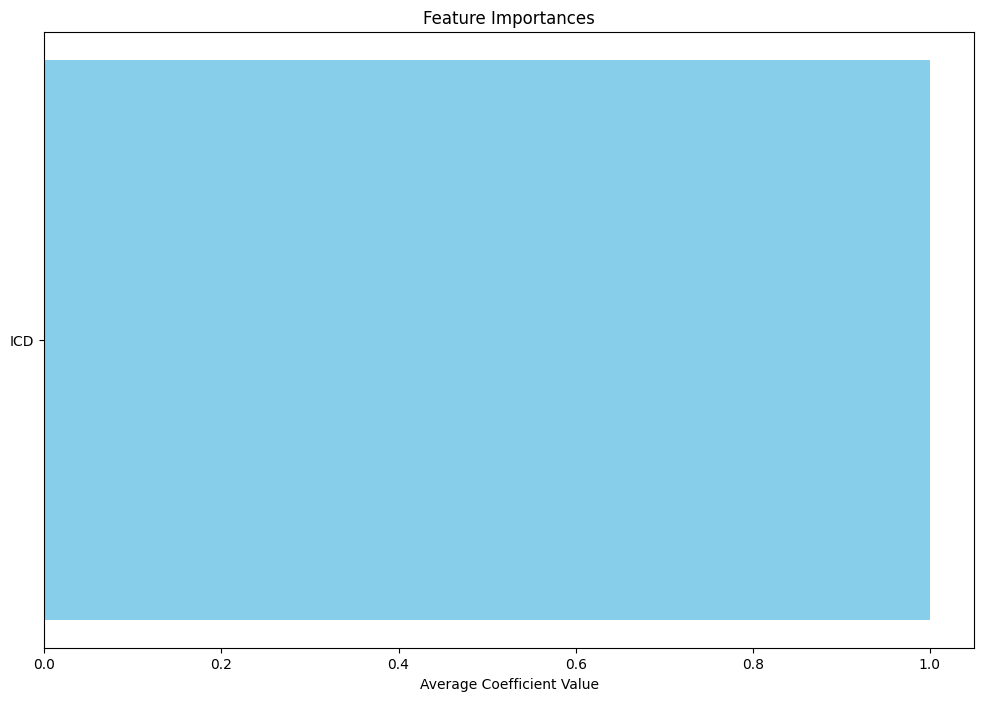

<Figure size 640x480 with 0 Axes>

In [24]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Save the DataFrame to a CSV file
feature_importance_df.to_csv('feat_importances.csv', index=False)

# Select top 10 and bottom 10 features
top_features = features[:1]
top_importances = importances[:1]
# bottom_features = features[-10:]
# bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features #+ bottom_features
plot_importances = top_importances #+ #bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig('feat_importances.png')

In [25]:

# Sum all confusion matrices to get overall counts
overall_cf_matrix = np.sum(cf_cv, axis=0)
print("Overall Confusion Matrix:\n", overall_cf_matrix)

Overall Confusion Matrix:
 [[1439   40]
 [ 403   32]]


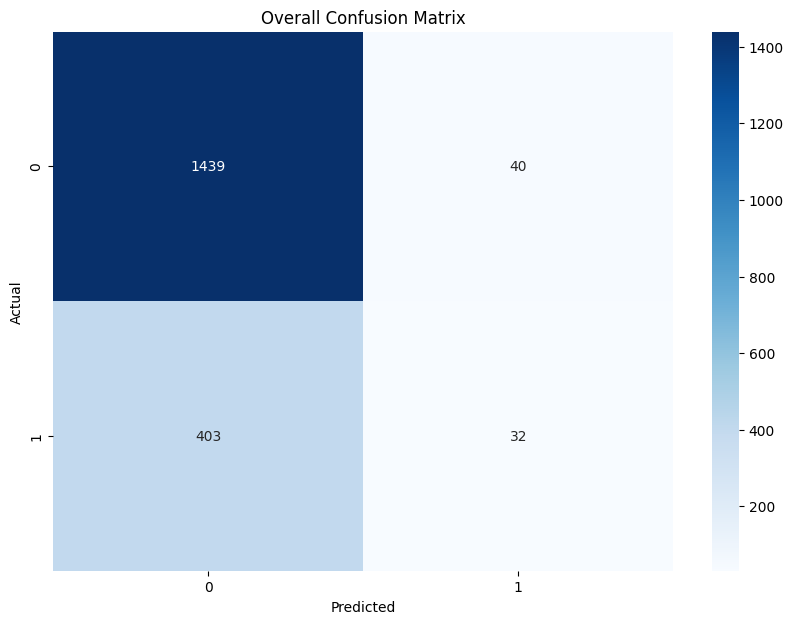

In [26]:
import seaborn as sns
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(overall_cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the figure
plt.savefig('overall_confusion_matrix.png')

# Show the figure
plt.show()


1
1


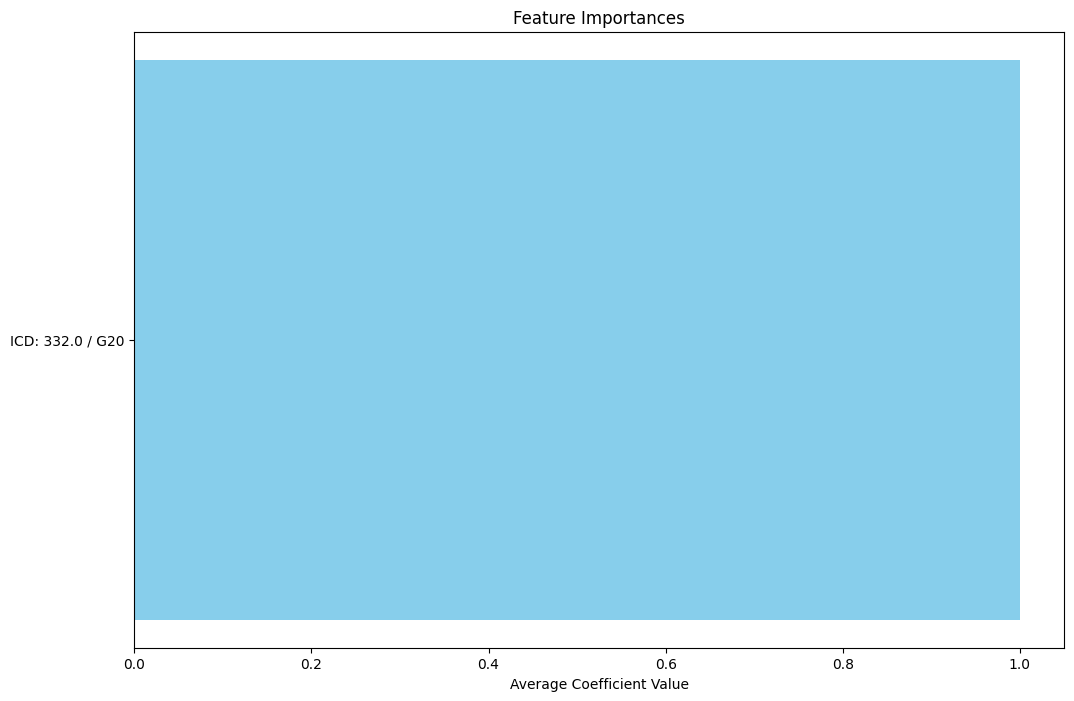

In [27]:
# before running this check for keywords
# Define custom feature names
custom_plot_features = [
    "ICD: 332.0 / G20"
]
print(len(custom_plot_features)) 
print(len(plot_features)) 
# Ensure the length of custom features matches the length of plot_features
assert len(custom_plot_features) == len(plot_features), "The number of custom features must match the number of plot features."
# Plot feature importances
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(plot_features)), plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

# Set custom y-axis labels
plt.yticks(range(len(plot_features)), custom_plot_features)

# Display the plot
plt.show()


In [28]:
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

# Calculate metrics for each fold
for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")


Metrics for Fold 1:
Accuracy: 0.7240
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 2:
Accuracy: 0.7656
Precision: 0.4444
Recall: 0.8649
F1 Score: 0.5872

Metrics for Fold 3:
Accuracy: 0.7812
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 4:
Accuracy: 0.7760
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 5:
Accuracy: 0.7801
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 6:
Accuracy: 0.7853
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 7:
Accuracy: 0.7958
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 8:
Accuracy: 0.7853
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 9:
Accuracy: 0.7644
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Fold 10:
Accuracy: 0.7277
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Overall Metrics:
Accuracy: 0.7685
Precision: 0.4444
Recall: 0.0736
F1 Score: 0.1262


In [31]:
print('a')

a


In [29]:
print(len(all_row_numbers))
print(len(all_true_labels))
print(len(all_predictions))
print(len(all_predictions_nonbin))

1914
1914
1914
1914


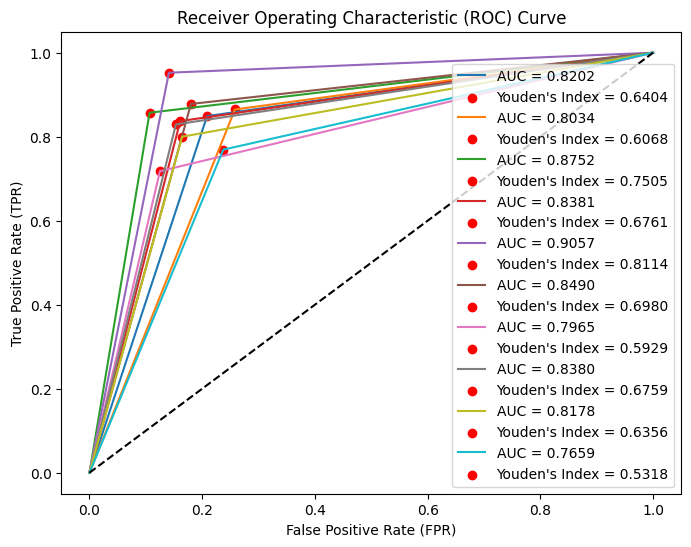

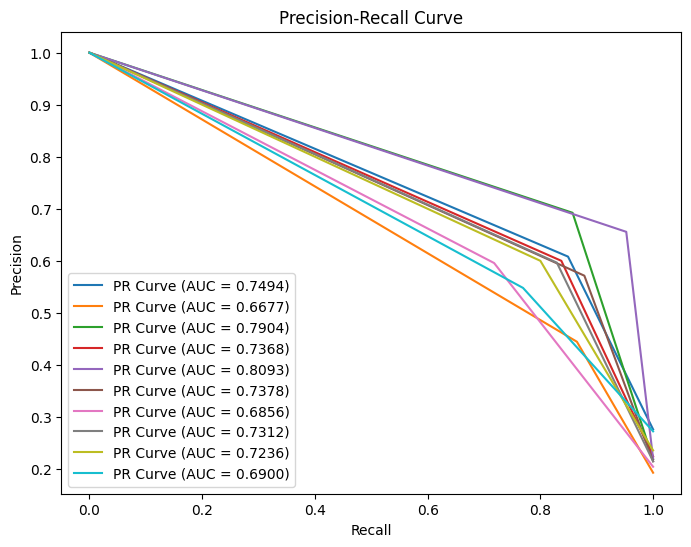

0.8309823237389388
0.05871559633027523


In [30]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('AUC_iter.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('PR_iter.png')
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction BINARY': all_predictions, 'prediction': all_predictions_nonbin})

# Save the DataFrame to a CSV file
results_df.to_csv('LR_iter_pred_rr.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv('LR_iter.csv')

# Print final Data
print(auc_final)
print(f1_final)